<img src="images/reddit.jpg" height="50%" width="50%">

<h1><center>An Analysis of the Prevalence of the US Events on Reddit</center></h1>
<center><b>By Nicholus Sakha</b><center>

<hr>
<h1><center>Introduction</center></h1>
<hr>
Reddit is a social media site that is widely used internationally where users can submit content such as text posts, images, and links that can be either upvoted to show that users like the content or downvote to show that users dislike the content. There exists smaller communities called subreddits that allow users to view content and view content for specific topics such as news, politics, video games, and lifestyle. Users can interact with content in a variety of ways, such as directly commenting to posts, gifting rewards to submissions or comments, or simply by upvoting or downvoting comments.

The year 2020 has been a turbulent one for many people worldwide with events such as the Coronavirus pandemic, the U.S. election, riots, and countless other events. As a result, there are more and more submissions with links to news articles that describe these events. With many of these events occuring within the United States, many users and subreddits have grown tired of hearing solely about what is happening in the U.S. and have opted to try to filter posts that were about U.S. events or politics.

In this tutorial, our goal is to verify whether the sentiment that U.S. events have becoming more prevealent over the year 2020. We will then look past the year 2020, and look at the past 11 years to see if there are any trends with how prevalence of the US, specifically if it has grown and if posts about the US are typically more popular than those that are not. 

We will use Pushshift, a Reddit API that allows us to search Reddit comments.

Install the dependencies needed for this project

<h1>The Difficulties Getting Data from Reddit</h1> 

Before diving into the data collection, it is important to learn more about the choice to use pushshift for this project, and the challenges that come with querying Reddit for data.

The main difficulty that comes with getting data from Reddit is that users are unable to query Reddit for date-specific results such as getting all of the most upvoted posts from a specified timeframe, as we are trying to do in this project. We would be able to search using the typical Reddit timeframe filters such as last day, last month, last year, etc. and while this would work well for the past year, it would fall off greatly the further back we go.

It is because of this that we turn to using PushShift to get data.

<h1>About PushShift, its Advantages and Shortcomings</h1>

Pushshift doesn't keep up to date data. It queries and updates periodically

https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/

https://www.reddit.com/r/pushshift/comments/eko1cm/the_pushshift_api_is_still_behind_due_to_an/

In [1]:
# In order to get make requests to get the data
import requests
import json

# To work with the data we are going to store it in a dataframe
import pandas as pd
import numpy as np
from datetime import datetime
import time

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

<hr>
<h1><center>Data Preparation</center></h1>
<hr>

<h1>Data Collection</h1> 

In order to get the data we need for this project, we need to query Pushshift in order to get the data required. Lets first make some functions. Lets make one that will get the data by querying Pushshift and get the top 100 posts from a subreddit.

With there being a limit of 100 per query, if we want to get more than 100 submissions per year, we are going to have to have some workaround if we want to have more than 100 submissions per year.

One approach would be to get 100 submissions for each of the 12 months, and then aggregate over them. However, this method would limit the type of exploratory analysis we could do. For example, if we wanted to see the distribution of month vs. upvotes, we would not see the whole picture if a month had posts that would belong in the top 1000 but was not collected in our sample because of our sample method.

What we are going to do instead is sample the whole year but each time keep track of the score. After each query, we will search for all posts below the lowest score from the last batch that was returned.

In [19]:
# Lets build the url which we will send requests to in order to get posts within a certain timeframe.

# For the sake of this project, we are interested in the top posts, but you can also change the 'sort_type' to 
# get posts based on the time they were created ('created_utc'), the number of comments the submission has ('num_comments'),
# or mumber of upvotes
def get_pushshift_data(term, start, end, subreddit, num_posts, score_threshold):
    # Limit the data fields we get back. We don't need everything!
    # It'd be useful to collect the flair as a potential y for machine learning predictions we do later
    f = ('created_utc,' +
         'full_link,' +
         'num_comments,' + 
         'score,' + 
         'subreddit,' +
         'title,' +
         'link_flair_text'
         )
    
    # Build the url which will send the data we are looking for
    url = ('https://api.pushshift.io/reddit/search/submission?' + 
           'title=' + str(term) +
           '&after=' + str(start) + 
           '&before=' + str(end) + 
           '&size=' + str(num_posts) + 
           '&sort=desc' +
           '&fields=' + f +
           '&score=<' + str(score_threshold) + 
           '&sort_type=score' + 
           '&subreddit=' + str(subreddit))
    # We are ensuring we are getting the highest posts with sort
    
    # Get the data, sleep so the successive calls do not trigger a 429 response
    time.sleep(1)
    r = requests.get(url)
    
    # Convert the request into a list of dict objects
    d = json.loads(r.text)
    
    # Return a list of dictionaries for the submissions
    return d['data']

# Lets test it by getting three posts from any subreddit between 11/08 - 11/10 2016
ex = get_pushshift_data('uighur', '2020-01-01', '2020-12-31', 'worldnews', 3, 1000000)
ex

[{'created_utc': 1595489764,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/hwbhtv/british_jews_board_of_deputies_compares_chinas/',
  'num_comments': 8716,
  'score': 83399,
  'subreddit': 'worldnews',
  'title': 'British Jews Board of Deputies compares China’s treatment of Uighur Muslims to Nazi Germany'},
 {'created_utc': 1595152588,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/hty3mf/uk_labour_party_calls_for_sanctions_on_chinese/',
  'num_comments': 5078,
  'score': 59955,
  'subreddit': 'worldnews',
  'title': 'UK Labour Party calls for sanctions on Chinese officials over Uighur repression'},
 {'created_utc': 1595190394,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/hu7gxq/china_is_using_uighur_labor_to_produce_face_masks/',
  'link_flair_text': 'COVID-19',
  'num_comments': 4576,
  'score': 46919,
  'subreddit': 'worldnews',
  'title': 'China Is Using Uighur Labor to Produce Face Masks'}]

# Data Curation
Now that we have a way to get the data, we need to store it in a dataframe. This is very simple with the way our dataframe is stored. The only thing we need to do now is write an iterative method to get the top 1000 posts per year. Given this, we can easily convert to a DataFrame. Lets do this to get the top 1000 posts from the 'worldnews' subreddit in 2020.

In [3]:
# num_top is expected to be a multiple of 100
def get_top_submissions_for_year(subreddit, term, year, num_top):
    return_lst = []
    num_iter = num_top//100
    # Preset the max score to 1 million and lower it based on the lowest submission score
    max_score = 1000000
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    
    for i in range(num_iter):
        return_lst = return_lst + get_pushshift_data(term, start_date, end_date, subreddit, 100, max_score)
        max_score = return_lst[-1]['score']
        
    return pd.DataFrame(return_lst)

# Example of getting the top 1000 entries from worldnews
df = get_top_submissions_for_year('worldnews', '', 2020, 1000)
df

,created_utc,full_link,link_flair_text,num_comments,score,subreddit,title
0,1591877734,https://www.reddit.com/r/worldnews/comments/h0...,Symbolic Move / Arms Exports Controlled by UK ...,4212,142729,worldnews,Scottish Parliament votes for immediate suspen...
1,1578134733,https://www.reddit.com/r/worldnews/comments/ej...,NaN,16927,105205,worldnews,"Bill Gates, the world's second-richest person ..."
2,1595117044,https://www.reddit.com/r/worldnews/comments/ht...,Russia,5735,101881,worldnews,Thousands rally in Russia for 8th straight day...
3,1578061085,https://www.reddit.com/r/worldnews/comments/ej...,Trump,13879,99544,worldnews,Trump accused of hypocrisy for ordering the po...
4,1586960839,https://www.reddit.com/r/worldnews/comments/g1...,Trump,5037,99528,worldnews,Italy hospital says Dr. Fauci 'welcome with op...
...,...,...,...,...,...,...,...
995,1605747501,https://www.reddit.com/r/worldnews/comments/jw...,Hong Kong,1803,497,worldnews,New Zealand joins Five Eyes allies in condemni...
996,1586865800,https://www.reddit.com/r/worldnews/comments/g1...,Already Submitted,28,495,worldnews,"Many older people are being ""airbrushed"" out o..."
997,1595423741,https://www.reddit.com/r/worldnews/comments/hv...,US internal news,102,495,worldnews,"Trump blasts Beijing in public, but privately ..."
998,1586791066,https://www.reddit.com/r/worldnews/comments/g0...,NaN,171,495,worldnews,Interstellar object ‘Oumuamua believed to be ‘...


<h1>Data Tidying</h1>

Now lets make the DataFrame more tidy, as its current layout is a bit unituitive. Lets swap the order of columns around and replace the created_utc column with a datetime object to improve what we can get from looking at the table. While the full link is useful for troubleshooting and confirming, it probably also will not be too useful in our analysis. Finally, lets rename the column titles to be a bit more descriptive.

In [4]:
def tidy_df(df):
    df = df.copy()
    date_time_lst = [datetime.utcfromtimestamp(x) for x in df['created_utc']]
    df['date'] = date_time_lst
    df = df.drop(['created_utc', 'full_link'], axis=1)
    if 'link_flair_text' not in df.columns:
        df['link_flair_text'] = np.nan
    df = df[['title','score','date','link_flair_text','num_comments','subreddit']]
    df = df.rename(columns={'title':'submission_name','link_flair_text':'flair'})

    return df

# Example tidying the df we got from the last step
d = tidy_df(df)
d

,submission_name,score,date,flair,num_comments,subreddit
0,Scottish Parliament votes for immediate suspen...,142729,2020-06-11 12:15:34,Symbolic Move / Arms Exports Controlled by UK ...,4212,worldnews
1,"Bill Gates, the world's second-richest person ...",105205,2020-01-04 10:45:33,NaN,16927,worldnews
2,Thousands rally in Russia for 8th straight day...,101881,2020-07-19 00:04:04,Russia,5735,worldnews
3,Trump accused of hypocrisy for ordering the po...,99544,2020-01-03 14:18:05,Trump,13879,worldnews
4,Italy hospital says Dr. Fauci 'welcome with op...,99528,2020-04-15 14:27:19,Trump,5037,worldnews
...,...,...,...,...,...,...
995,New Zealand joins Five Eyes allies in condemni...,497,2020-11-19 00:58:21,Hong Kong,1803,worldnews
996,"Many older people are being ""airbrushed"" out o...",495,2020-04-14 12:03:20,Already Submitted,28,worldnews
997,"Trump blasts Beijing in public, but privately ...",495,2020-07-22 13:15:41,US internal news,102,worldnews
998,Interstellar object ‘Oumuamua believed to be ‘...,495,2020-04-13 15:17:46,NaN,171,worldnews


<h1>Getting all the Data</h1>

Now that we have all these functions in place, lets get all the data that we will need. We will define a function that will combine the functions from all the previous steps and return a single DataFrame ready for work

Since we have to include a wait so that we do not get a 429 Response (Too Many Requests), it would be much easier, especially in the future to write all this data to a csv so we can read it later.

In [5]:
def get_data(subreddit, term, year, num_top):
    return tidy_df(get_top_submissions_for_year(subreddit, term, year, num_top))

# Function to get all world news data
def get_data_10_years(subreddit):
    year_lst = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
    return_lst = []
    for year in year_lst:
        df = get_data(subreddit, '', year, 1000)
        return_lst.append(df)
        df.to_csv(subreddit + '_' + str(year) + '.csv', index = False, header = True)
    return return_lst
       
# Keep a boolean value to determine if we need to re-collect data
fresh_run = False

if (fresh_run):
    worldnews_lst = get_data_10_years('worldnews')

<hr>
<h1><center>Exploratory Data Analysis</center></h1>
<hr>

Now that we have the data, we can do some exploratory data analysis. For the of reproducability, I have stored the dataframes that I will using in my analysis in this zip so that they can be downloaded if anything were to happen to either the Reddit API or the PushShift API. <a href="data.zip">Click here to download the data in a .zip file.</a> Unfortunately, we will have to reconvert the date column into a datetime object when we read it from a csv.

To start, lets load the .csv files we created in the last part into variables we will perform analysis on.

In [6]:
def convert_str_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

# My csv files are in a directory called data
worldnews_2020 = convert_str_datetime(pd.read_csv('data/worldnews_2020.csv'))
worldnews_2019 = convert_str_datetime(pd.read_csv('data/worldnews_2019.csv'))
worldnews_2018 = convert_str_datetime(pd.read_csv('data/worldnews_2018.csv'))
worldnews_2017 = convert_str_datetime(pd.read_csv('data/worldnews_2017.csv'))
worldnews_2016 = convert_str_datetime(pd.read_csv('data/worldnews_2016.csv'))
worldnews_2015 = convert_str_datetime(pd.read_csv('data/worldnews_2015.csv'))
worldnews_2014 = convert_str_datetime(pd.read_csv('data/worldnews_2014.csv'))
worldnews_2013 = convert_str_datetime(pd.read_csv('data/worldnews_2013.csv'))
worldnews_2012 = convert_str_datetime(pd.read_csv('data/worldnews_2012.csv'))
worldnews_2011 = convert_str_datetime(pd.read_csv('data/worldnews_2011.csv'))
worldnews_2010 = convert_str_datetime(pd.read_csv('data/worldnews_2010.csv'))



To begin, lets look at the distribution of upvotes vs. time for the year 2020. There were three notable events in the US that garnered a lot of international attention, those being:

1) Initial COVID outbreaks in the US in March/April

2) BLM Protests that occurred after the death of George Floyd in May/June

3) The US 2020 Elections in November

By visualizing this distribution, we will be able to see if there is more popularity during these months and likely for submissions about these topics, or if it is more uniform, we will less evidence to reject the null hypothesis that the US events are not more popular than other events.

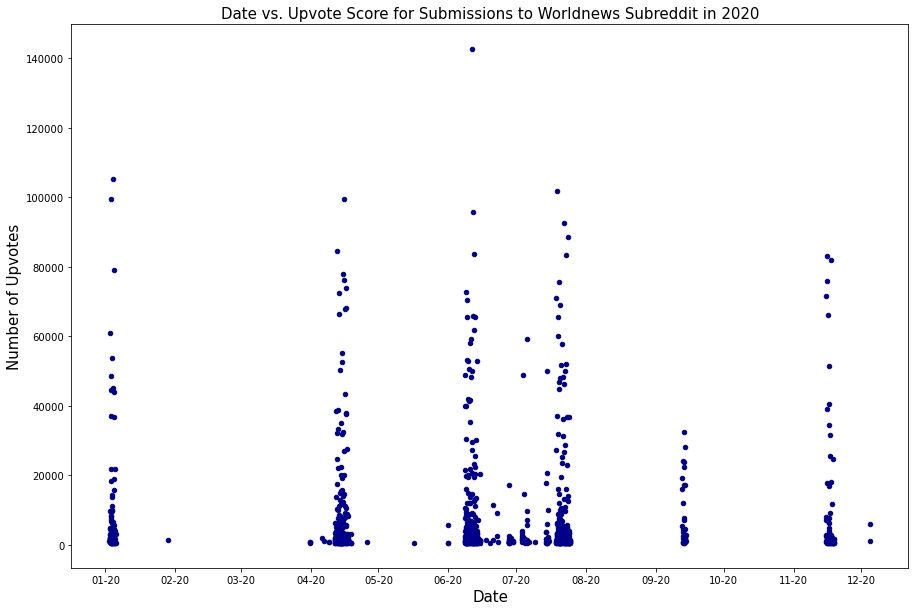

In [7]:
plot = worldnews_2020.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

Looking at the scatter plot above, it would appear that our predicition may at least be partially true. Lets investigate this further by looking making simple classifiers for the title to see whether they fit in our category.

To do this, lets just make a list of terms that may be in the title of a post about that topic. If any term is within that title, we would keep it and display its points

253


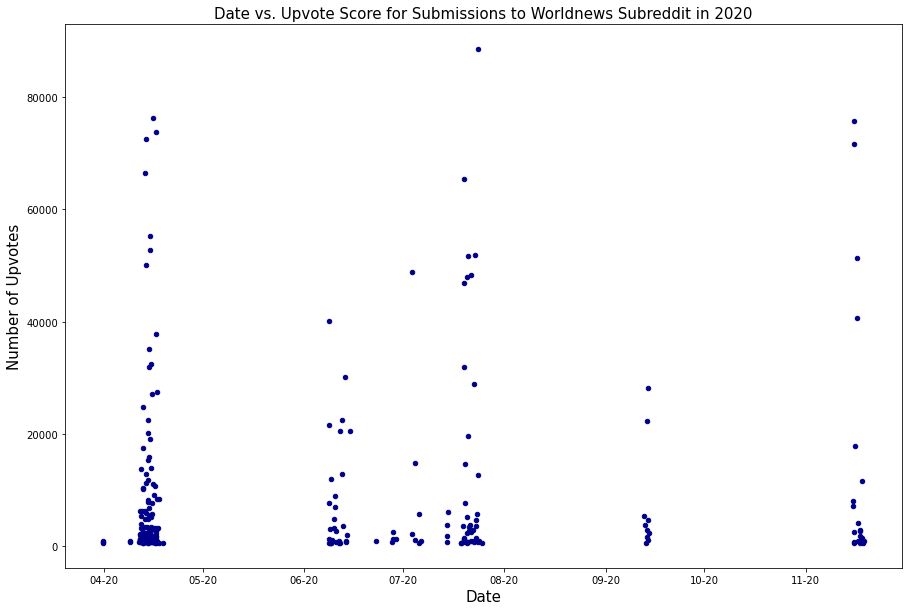

In [8]:
terms = '(?i)covid|covid-19|corona|coronavirus'
#  or worldnews_2020['flair'] == 'COVID-19'
lst_1 = worldnews_2020['submission_name'].str.contains(terms).tolist()
lst_2 = (worldnews_2020['flair'] == 'COVID-19').tolist()
filter_lst = []
for i in range(len(lst_1)):
    filter_lst.append(lst_1[i] or lst_2[i])
filter_lst = pd.Series(filter_lst)
temp = worldnews_2020[filter_lst]
print(len(temp))
plot = temp.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

54


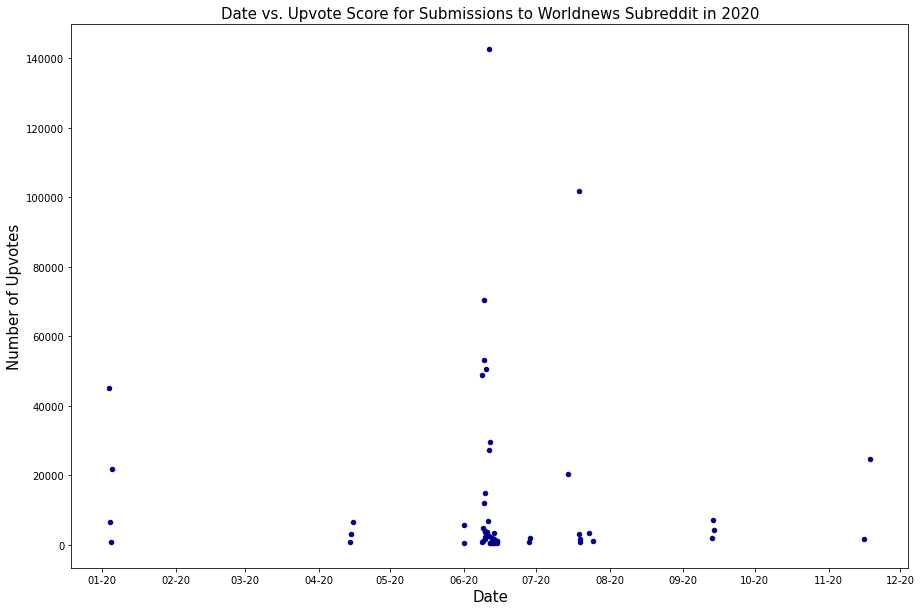

In [9]:
terms = '(?i)blm|riot|protest|floyd|black lives matter|defund|rioters'
#  or worldnews_2020['flair'] == 'COVID-19'
temp = worldnews_2020[worldnews_2020['submission_name'].str.contains(terms)]
print(len(temp))
plot = temp.plot.scatter(x='date', y='score', c='DarkBlue', figsize=(15,10), fontsize = 10)
plot.set_title('Date vs. Upvote Score for Submissions to Worldnews Subreddit in 2020', fontsize = 15)
plot.set_ylabel('Number of Upvotes', fontsize = 15)
plot.set_xlabel('Date', fontsize = 15)

# Format date
date_formatter = DateFormatter('%m-%y')
plot.xaxis.set_major_formatter(date_formatter)

# Update ticks
plot.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

In [30]:
f = ('created_utc,' +
         'full_link,' +
         'num_comments,' + 
         'score,' + 
         'subreddit,' +
         'title,' +
         'link_flair_text'
         )
    
    # Build the url which will send the data we are looking for
url = ('https://api.pushshift.io/reddit/search/submission?' + 
           '&author=Eurynom0s'
           '&size=' + str(100) + 
           '&fields=' + f +
           '&sort_type=score' + 
           '&subreddit=' + 'worldnews')
    # We are ensuring we are getting the highest posts with sort
    
    # Get the data, sleep so the successive calls do not trigger a 429 response
r = requests.get(url)
    
    # Convert the request into a list of dict objects
d = json.loads(r.text)
    
    # Return a list of dictionaries for the submissions
d['data']

[{'created_utc': 1536178460,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/9daguk/trudeau_criticizes_trump_arguing_canada_needs_an/',
  'link_flair_text': 'Trump',
  'num_comments': 3323,
  'score': 52977,
  'subreddit': 'worldnews',
  'title': 'Trudeau criticizes Trump, arguing Canada needs an independent NAFTA dispute system because the U.S. president breaks the rules'},
 {'created_utc': 1502385660,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/6sutd7/north_korea_senile_donald_trump_plays_too_much/',
  'link_flair_text': 'Trump',
  'num_comments': 5566,
  'score': 51943,
  'subreddit': 'worldnews',
  'title': 'North Korea: Senile Donald Trump Plays Too Much Golf'},
 {'created_utc': 1517265032,
  'full_link': 'https://www.reddit.com/r/worldnews/comments/7tw6hi/leaked_govt_report_every_brexit_option_will_hurt/',
  'link_flair_text': 'Brexit',
  'num_comments': 5570,
  'score': 47407,
  'subreddit': 'worldnews',
  'title': 'Leaked Gov’t Report: Every Brexit O

How to deal with not all posts being present in dataset problem?

Plans:

1) Investigate whether the above frequency centers can be attributed to the posts we talked about
-> using simple classifiers, i.e. title contains riots, blm etc etc

2) Calculate Frequency of words using a BoW and IDF representation to see which terms are the most popular, per year

3) Use simple classier to mark submissions as either US or not (whether they contain US or Trump, e.g.) and then find a regression line for the data.

4) Train ML model to predict average score on posts given that they are about the US and year, with interaction terms